# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import defaultdict
import re

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats

In [3]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [96]:
# variables for LFP extraction
# Frequencies to get LFP
FREQ_MIN = 0.5
FREQ_MAX = 300
# Frequency of electrical noise to remove
FREQ = 60

In [102]:
# TODO: Check if we can remove this
# Variables for getting the trial information
RESAMPLE_RATE = 1000
# TRIAL_DURATION=10
# TRIAL_TIME_STAMP_DURATION = 1000*10

In [99]:
# Variables for calculating the power spectrum
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 



In [100]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [8]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

In [9]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [11]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [12]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     6.1       NaN        15       14      13      31   
1       1     6.2       NaN        15       14      13      31   
2       1     6.3       NaN        15       14      13      31   
3       1     6.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                  21.0                  15.0                 14.0   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   9.0                  31.0                 30.0   
7                  15.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                13.0                16.0  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                29.0                28.0  
7                29.0                28.0

### Getting the subject IDs from the file name

In [13]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [14]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [15]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [16]:
all_trials_df["recording_dir"].unique()

array(['20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
       '20221215_145401_comp_amd_om_6_1_and_6_3',
       '20221202_134600_omission_and_competition_subject_6_1_and_6_2',
       '20221214_125409_om_and_comp_6_1_and_6_3'], dtype=object)

- Getting a list of all the subjects through the recording name

In [17]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [18]:
all_trials_df["all_subjects"].head()

0    [1.4, 1.3]
1    [1.4, 1.3]
2    [1.4, 1.3]
3    [1.4, 1.3]
4    [1.4, 1.3]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [19]:
all_trials_df["subject_info"].head()

0    1-3_t3b3L_box2
1    1-3_t3b3L_box2
2    1-3_t3b3L_box2
3    1-3_t3b3L_box2
4    1-3_t3b3L_box2
Name: subject_info, dtype: object

In [20]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [21]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject  
0         NaN          49111.0   [1.4, 1.3]             1.3  
1         NaN         169111.0   [1.4, 1.3]             1.3  
2         NaN         284111.0   [1.4, 1.3]             1.3  
3         NaN         374111.0   [1.4, 1.3]             1.3  
4         NaN         429111.0   [1.4, 1.3]             1.3

- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [22]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [23]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          49111.0   [1.4, 1.3]             1.3          lose  
1         NaN         169111.0   [1.4, 1.3]             1.3           win  
2         NaN         284111.0   [1.4, 1.3]             1.3          lose  
3         NaN         374111.0   [1.4, 1.3]             1.3          lose  
4         NaN         429111.0   [1.4, 1.3]             1.3          lose

In [24]:
all_trials_df

time  state                                      recording_dir  \
0     9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1    12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2    14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3    16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4    17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
..          ...    ...                                                ...   
636  56250471.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
637  58050469.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
638  59950467.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
639  62350467.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
640  63950466.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   

                                        recording_file           din  \
0    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
..                                                 ...           ...   
636  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
637  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
638  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
639  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
640  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

     time_stamp_index                                         video_file  \
0            982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1           3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2           5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3           7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4           8582220.0  20230612_101430_standard_comp_to_training_D1_s...   
..                ...                                                ...   
636        53298568.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
637        55098566.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
638        56998564.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
639        59398564.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
640        60998563.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

     video_frame  video_number             subject_info condition  \
0          980.0           2.0           1-3_t3b3L_box2       1.4   
1         3376.0           2.0           1-3_t3b3L_box2       1.3   
2         5671.0           2.0           1-3_t3b3L_box2       1.4   
3         7468.0           2.0           1-3_t3b3L_box2       1.4   
4         8566.0           2.0           1-3_t3b3L_box2       1.4   
..           ...           ...                      ...       ...   
636      60112.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   
637      62355.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   
638      64724.0           1.0  6_1_top_1_base_2_vs_6_3       6.1   
639      67716.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   
640      69710.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   

    competition_closeness Unnamed: 13  resampled_index all_subjects  \
0             Subj 2 Only         NaN          49111.0   [1.4, 1.3]   
1             Subj 1 Only         NaN         169111.0   [1.4, 1.3]   
2             Subj 2 Only         NaN         284111.0   [1.4, 1.3]   
3             Subj 2 Only         NaN         374111.0   [1.4, 1.3]   
4             Subj 2 Only         NaN         429111.0   [1.4, 1.3]   
..                    ...         ...              ..

### Extracting the LFP

In [25]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in all_session_dir:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


- Filtering for all trials that have labels

In [26]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [27]:
baseline_df = all_trials_df.copy()

In [28]:
baseline_df["trial_outcome"] = baseline_df["trial_outcome"] + "_baseline"

In [29]:
baseline_df["resampled_index"] = baseline_df["resampled_index"] - (RESAMPLE_RATE * TRIAL_DURATION)

In [30]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          49111.0   [1.4, 1.3]             1.3          lose  
1         NaN         169111.0   [1.4, 1.3]             1.3           win  
2         NaN         284111.0   [1.4, 1.3]             1.3          lose  
3         NaN         374111.0   [1.4, 1.3]             1.3          lose  
4         NaN         429111.0   [1.4, 1.3]             1.3          lose

In [31]:
baseline_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject  trial_outcome  
0         NaN          39111.0   [1.4, 1.3]             1.3  lose_baseline  
1         NaN         159111.0   [1.4, 1.3]             1.3   win_baseline  
2         NaN         274111.0   [1.4, 1.3]             1.3  lose_baseline  
3         NaN         364111.0   [1.4, 1.3]             1.3  lose_baseline  
4         NaN         419111.0   [1.4, 1.3]             1.3  lose_baseline

In [32]:
all_trials_df = pd.concat([all_trials_df, baseline_df]).reset_index(drop=True).sort_values(["recording_file", "time"])

In [33]:
all_trials_df["trial_outcome"].unique()

array(['rewarded', 'rewarded_baseline', 'omission', 'omission_baseline',
       'win', 'win_baseline', 'lose', 'lose_baseline'], dtype=object)

In [34]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [35]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     6.1       NaN        15       14      13      31   
1       1     6.2       NaN        15       14      13      31   
2       1     6.3       NaN        15       14      13      31   
3       1     6.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                  21.0                  15.0                 14.0   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   9.0                  31.0                 30.0   
7                  15.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                13.0                16.0  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                29.0                28.0  
7                29.0                28.0

## Power Calculation

In [36]:
all_trials_df.head()

time  state                            recording_dir  \
497   4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
1027  4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
498   5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
1028  5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
499   7759946.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   

                                         recording_file           din  \
497   20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1027  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
498   20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1028  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
499   20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
497          1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1027         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
498          3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1028         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
499          4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

      video_frame  video_number             subject_info condition  \
497        1405.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
1027       1405.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
498        3002.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
1028       3002.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   
499        4798.0           1.0  6_1_top_1_base_2_vs_6_3  rewarded   

     competition_closeness Unnamed: 13  resampled_index all_subjects  \
497                    NaN         NaN          70402.0   [6.1, 6.3]   
1027                   NaN         NaN          60402.0   [6.1, 6.3]   
498                    NaN         NaN         150402.0   [6.1, 6.3]   
1028                   NaN         NaN         140402.0   [6.1, 6.3]   
499                    NaN         NaN         240402.0   [6.1, 6.3]   

     current_subject      trial_outcome  
497              6.1           rewarded  
1027             6.1  rewarded_baseline  
498              6.1           rewarded  
1028             6.1  rewarded_baseline  
499              6.1           rewarded

- Adding all the brain region to ch information

In [37]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [38]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

- Creating a new row for each brain region

In [39]:
brain_region_col = [col for col in CHANNEL_MAPPING_DF if "spike_interface" in col]

In [40]:
id_cols = [col for col in channel_map_and_all_trials_df.columns if col not in brain_region_col]

In [41]:
melted_channel_map_and_all_trials_df = channel_map_and_all_trials_df.melt(id_vars=id_cols ,value_vars=brain_region_col, var_name='brain_region', value_name='channel')


In [42]:
melted_channel_map_and_all_trials_df.head()

time  state                            recording_dir  \
0  4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
1  4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2  5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
3  5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
4  7759946.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file           din  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4         4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

   video_frame  video_number             subject_info  ... Cohort Subject  \
0       1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
1       1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
2       3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
3       3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
4       4798.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   

  eib_mPFC  eib_vHPC eib_BLA eib_LH eib_MD  \
0      NaN        15      14     13     31   
1      NaN        15      14     13     31   
2      NaN        15      14     13     31   
3      NaN        15      14     13     31   
4      NaN        15      14     13     31   

                                          all_ch_lfp          brain_region  \
0  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
1  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
2  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
3  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
4  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   

   channel  
0     21.0  
1     21.0  
2     21.0  
3     21.0  
4     21.0  

[5 rows x 27 columns]

In [43]:
melted_channel_map_and_all_trials_df.tail()

time  state                                      recording_dir  \
5295  68560944.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5296  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5297  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5298  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5299  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   

                                         recording_file           din  \
5295  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5296  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5297  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5298  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5299  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
5295        66058063.0  20230620_114347_standard_comp_to_omission_D4_s...   
5296        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   
5297        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   
5298        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   
5299        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   

      video_frame  video_number     subject_info  ... Cohort Subject eib_mPFC  \
5295      65986.0           1.0  1-2_t3b3L_box_1  ...      2     1.2      NaN   
5296      66931.0           2.0  1-2_t3b3L_box_1  ...      2     1.2      NaN   
5297      66984.0           1.0  1-2_t3b3L_box_1  ...      2     1.2      NaN   
5298      66931.0           2.0  1-2_t3b3L_box_1  ...      2     1.2      NaN   
5299      66984.0           1.0  1-2_t3b3L_box_1  ...      2     1.2      NaN   

      eib_vHPC eib_BLA eib_LH eib_MD  \
5295        31      30     29     28   
5296        31      30     29     28   
5297        31      30     29     28   
5298        31      30     29     28   
5299        31      30     29     28   

                                             all_ch_lfp        brain_region  \
5295  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
5296  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
5297  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
5298  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
5299  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   

      channel  
5295     28.0  
5296     28.0  
5297     28.0  
5298     28.0  
5299     28.0  

[5 rows x 27 columns]

- Getting the traces for each trial for each brain region

In [44]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [45]:
melted_channel_map_and_all_trials_df["trial_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=x["resampled_index"], end_frame=x["resampled_index"] + RESAMPLE_RATE * TRIAL_DURATION).T[0], axis=1)

In [46]:
melted_channel_map_and_all_trials_df["trial_trace"] = melted_channel_map_and_all_trials_df["trial_trace"].apply(lambda x: x[:RESAMPLE_RATE*TRIAL_DURATION])

In [47]:
melted_channel_map_and_all_trials_df

time  state                                      recording_dir  \
0      4359951.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
1      4359951.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
2      5959954.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
3      5959954.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
4      7759946.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
...          ...    ...                                                ...   
5295  68560944.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5296  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5297  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5298  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   
5299  69560954.0    1.0  20230620_114347_standard_comp_to_omission_D4_s...   

                                         recording_file           din  \
0     20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1     20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2     20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3     20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4     20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
...                                                 ...           ...   
5295  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5296  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5297  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5298  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   
5299  20230620_114347_standard_comp_to_omission_D4_s...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
0            1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1            1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2            3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3            3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4            4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
...                ...                                                ...   
5295        66058063.0  20230620_114347_standard_comp_to_omission_D4_s...   
5296        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   
5297        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   
5298        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   
5299        67058073.0  20230620_114347_standard_comp_to_omission_D4_s...   

      video_frame  video_number             subject_info  ... Subject  \
0          1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...     6.1   
1          1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...     6.1   
2          3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...     6.1   
3          3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...     6.1   
4          4798.0           1.0  6_1_top_1_base_2_vs_6_3  ...     6.1   
...           ...           ...                      ...  ...     ...   
5295      65986.0           1.0          1-2_t3b3L_box_1  ...     1.2   
5296      66931.0           2.0          1-2_t3b3L_box_1  ...     1.2   
5297      66984.0           1.0          1-2_t3b3L_box_1  ...     1.2   
5298      66931.0           2.0          1-2_t3b3L_box_1  ...     1.2   
5299      66984.0           1.0          1-2_t3b3L_box_1  ...     1.2   

     eib_mPFC eib_vHPC  eib_BLA eib_LH eib_MD  \
0         NaN       15       14     13     31   
1         NaN       15       14     13     31   
2         NaN       15       14     13     31   
3         NaN       15       14     13     31   
4         NaN       15       14     13     31   
...       ...      ...      ...    ...    ...   
5295      NaN       31       30     29     28   
5296

In [48]:
melted_channel_map_and_all_trials_df["trial_zscore"] = melted_channel_map_and_all_trials_df["trial_trace"].apply(lambda x: stats.zscore(x))

melted_channel_map_and_all_trials_df["trial_zscore"] = melted_channel_map_and_all_trials_df["trial_zscore"].apply(lambda x: x[x <= 2])

In [49]:
melted_channel_map_and_all_trials_df["trial_zscore"]

0       [-1.2234846863688307, -1.3384517380339445, -1....
1       [-0.6535397404353301, -0.6792592303573072, -0....
2       [-0.9601716075887397, -1.6443569730989784, -1....
3       [-1.6345438675734256, -0.20703048634304905, 0....
4       [-1.7410672190530256, -1.7410672190530256, -1....
                              ...                        
5295    [1.182247436778107, 1.313596522748731, 1.57045...
5296    [1.2537899574709974, 0.8007900512612373, 0.355...
5297    [1.2537899574709974, 0.8007900512612373, 0.355...
5298    [1.5848423477642544, 0.9369218563849324, 0.254...
5299    [1.5848423477642544, 0.9369218563849324, 0.254...
Name: trial_zscore, Length: 5300, dtype: object

- Calcuating the power at each frequency band

In [50]:
melted_channel_map_and_all_trials_df["multitaper"] = melted_channel_map_and_all_trials_df["trial_zscore"].apply(lambda x: Multitaper(time_series=x, 
                                                                                                                                     sampling_frequency=RESAMPLE_RATE,
                                                                                                                                    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
                                                                                                                                    time_window_duration=TIME_WINDOW_DURATION,
                                                                                                                                    time_window_step=TIME_WINDOW_STEP))

In [51]:
melted_channel_map_and_all_trials_df["connectivity"] = melted_channel_map_and_all_trials_df["multitaper"].apply(lambda x: Connectivity.from_multitaper(x))

In [52]:
melted_channel_map_and_all_trials_df["frequencies"] = melted_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.frequencies)

In [53]:
melted_channel_map_and_all_trials_df["power"] = melted_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.power().squeeze())

In [54]:
melted_channel_map_and_all_trials_df.head()

time  state                            recording_dir  \
0  4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
1  4359951.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2  5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
3  5959954.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
4  7759946.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file           din  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
1         1408048.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
3         3008051.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
4         4808043.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

   video_frame  video_number             subject_info  ... eib_MD  \
0       1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...     31   
1       1405.0           1.0  6_1_top_1_base_2_vs_6_3  ...     31   
2       3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...     31   
3       3002.0           1.0  6_1_top_1_base_2_vs_6_3  ...     31   
4       4798.0           1.0  6_1_top_1_base_2_vs_6_3  ...     31   

                                          all_ch_lfp          brain_region  \
0  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
1  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
2  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
3  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
4  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   

   channel                                        trial_trace  \
0       21  [-572, -626, -595, -415, -237, -126, -29, 52, ...   
1       21  [-311, -323, -343, -361, -501, -779, -911, -77...   
2       21  [-475, -809, -894, -846, -1063, -1185, -779, -...   
3       21  [-810, -104, 19, -479, -696, -272, 375, 565, 1...   
4       21  [-843, -843, -635, -506, -577, -662, -640, -65...   

                                        trial_zscore  \
0  [-1.2234846863688307, -1.3384517380339445, -1....   
1  [-0.6535397404353301, -0.6792592303573072, -0....   
2  [-0.9601716075887397, -1.6443569730989784, -1....   
3  [-1.6345438675734256, -0.20703048634304905, 0....   
4  [-1.7410672190530256, -1.7410672190530256, -1....   

                                          multitaper  \
0  Multitaper(sampling_frequency=1000, time_halfb...   
1  Multitaper(sampling_frequency=1000, time_halfb...   
2  Multitaper(sampling_frequency=1000, time_halfb...   
3  Multitaper(sampling_frequency=1000, time_halfb...   
4  Multitaper(sampling_frequency=1000, time_halfb...   

                                        connectivity  \
0  <spectral_connectivity.connectivity.Connectivi...   
1  <spectral_connectivity.connectivity.Connectivi...   
2  <spectral_connectivity.connectivity.Connectivi...   
3  <spectral_connectivity.connectivity.Connectivi...   
4  <spectral_connectivity.connectivity.Connectivi...   

                                         frequencies  \
0  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
1  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
2  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
3  [0.0, 0.3333333333333333, 0.6666666666666666, ...   
4  [0.0, 0.3333333333333333, 0.6666666666666666, ...   

                                               power  
0  [[0.0015525155158731293, 0.0021222409406660564...  
1  [[0.00260410290098180

In [55]:
grouped_all_trials_df = melted_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_outcome', 'recording_file', 'current_subject']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [56]:
grouped_all_trials_df = melted_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_outcome', 'current_subject']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [57]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [58]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [59]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [60]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [61]:
color_list = ["b", "g", "r", "m", "y", "pink", "purple"]

In [62]:
id_to_color = { id: color_list[index] for index, id in enumerate(sorted(grouped_all_trials_df["current_subject"].unique()))}

In [63]:
id_to_color

{'1.1': 'b', '1.2': 'g', '1.3': 'r', '1.4': 'm', '6.1': 'y'}

In [64]:
outcome_to_style = {'lose': "solid", 'omission': "dotted", 'rewarded': "dotted", 'win': "solid"}

In [65]:
outcome_to_style = {'lose': "-", 'omission': "--", 'rewarded': "-", 'win': "--"}

In [66]:
outcome_to_style = {'lose': "solid", 'omission': "dashed", 'rewarded': "dashed", 'win': "solid"}

In [67]:
grouped_all_trials_df["trial_outcome"].unique()

array(['lose', 'lose_baseline', 'omission', 'omission_baseline',
       'rewarded', 'rewarded_baseline', 'win', 'win_baseline'],
      dtype=object)

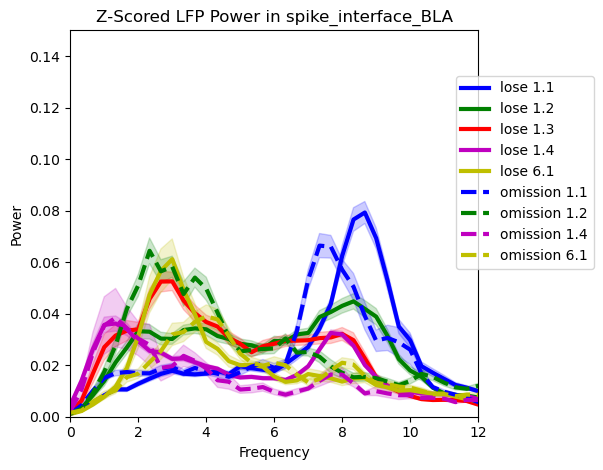

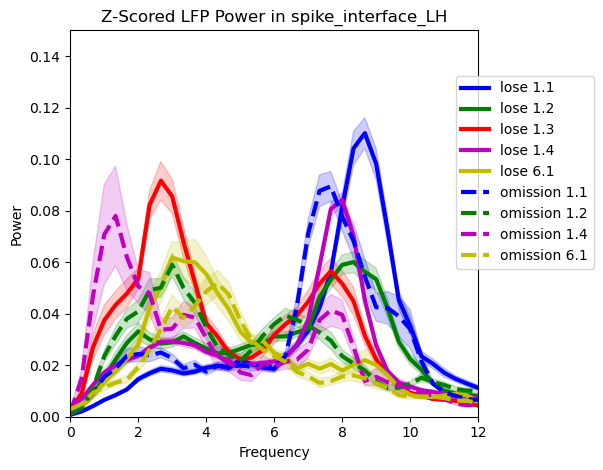

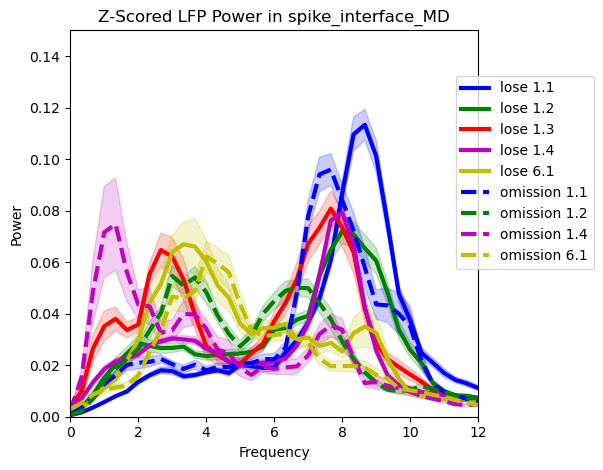

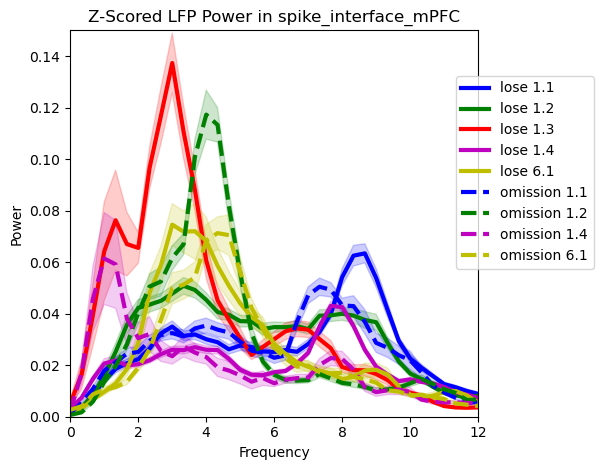

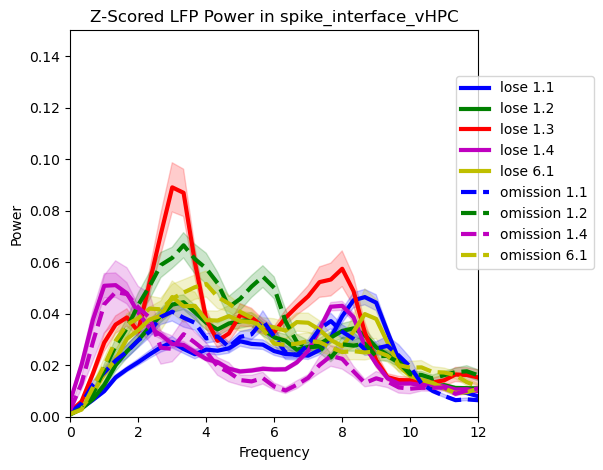

In [68]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 12)
    plt.ylim(0, 0.15)
    # plt.yscale("log")

    for outcome in ["lose", "omission"]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, row["current_subject"]), color=id_to_color[row["current_subject"]], linestyle=outcome_to_style[outcome], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=id_to_color[row["current_subject"]])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/z_scored_lose_and_omission_for_{}.png".format(region))
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

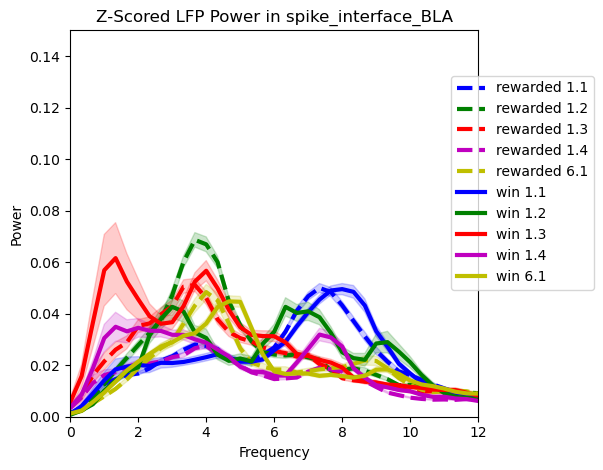

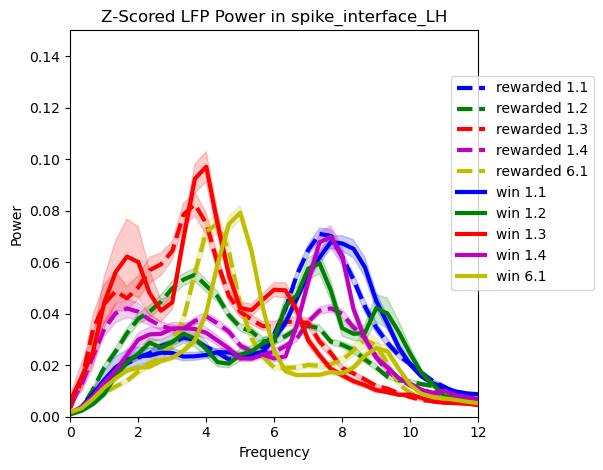

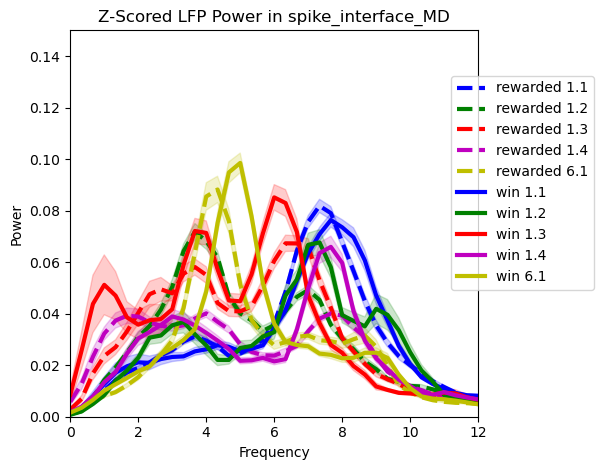

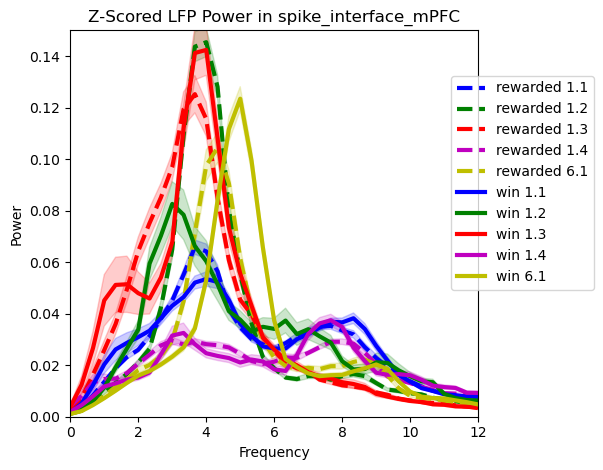

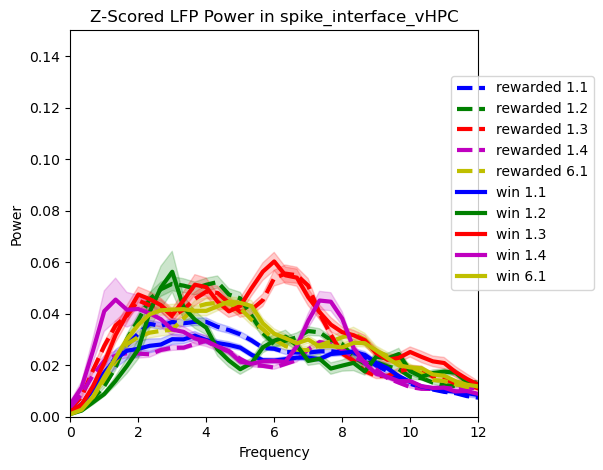

In [69]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 12)
    plt.ylim(0, 0.15)
    # plt.yscale("log")
    for outcome in ["rewarded", "win"]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, row["current_subject"]), color=id_to_color[row["current_subject"]], linestyle=outcome_to_style[outcome], linewidth=3)
            # ax.lines[0].set_linestyle(outcome_to_style[outcome])
            plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=id_to_color[row["current_subject"]])
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()

    plt.savefig("./proc/z_scored_win_and_rewarded_for_{}.png".format(region))

    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

## Drawing plots with baseline

1 plot for each subject 

In [70]:
outcome_to_style = {k: ("dashed" if "baseline" in k else "solid") for k in grouped_all_trials_df["trial_outcome"].unique()}

In [71]:
outcome_to_style

{'lose': 'solid',
 'lose_baseline': 'dashed',
 'omission': 'solid',
 'omission_baseline': 'dashed',
 'rewarded': 'solid',
 'rewarded_baseline': 'dashed',
 'win': 'solid',
 'win_baseline': 'dashed'}

In [72]:
num_lines = 3

In [73]:
# Generate colors from the "Blues" colormap
losing_colors = cm.Oranges(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
winning_colors = cm.Blues(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
rewarded_colors = cm.Greens(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
omission_colors = cm.Reds(np.linspace(0.5, 1, num_lines))

In [74]:
outcome_to_color = {'lose': losing_colors[2],
 'lose_baseline': losing_colors[0],
 'omission': omission_colors[2],
 'omission_baseline': omission_colors[0],
 'rewarded': rewarded_colors[2],
 'rewarded_baseline': rewarded_colors[0],
 'win': winning_colors[2],
 'win_baseline': winning_colors[0]}

In [75]:
outcome_to_color = {'lose': "orange",
 'lose_baseline': losing_colors[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': rewarded_colors[0],
 'win': "blue",
 'win_baseline': winning_colors[0]}

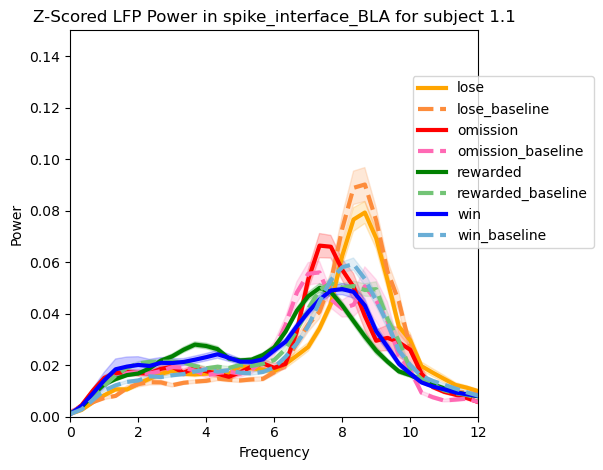

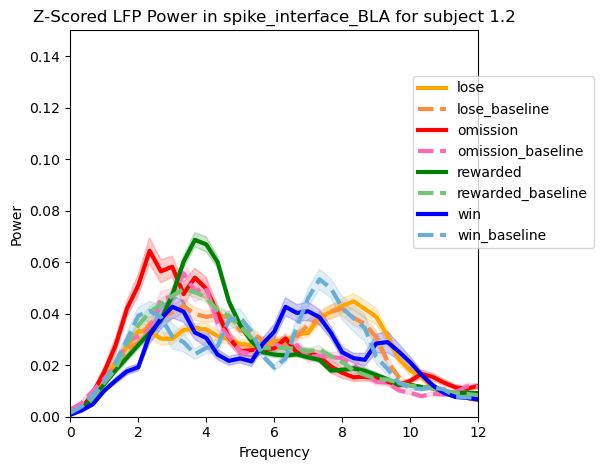

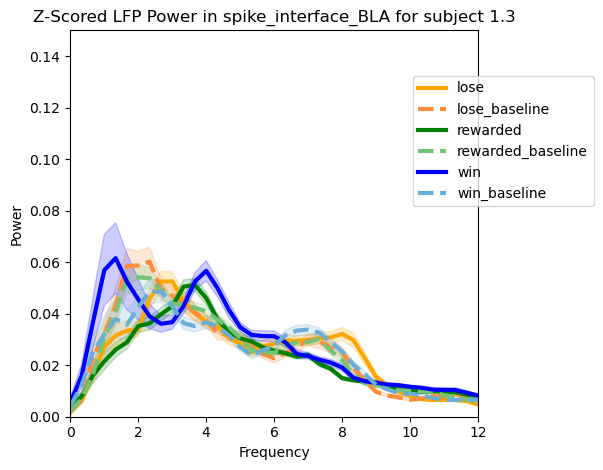

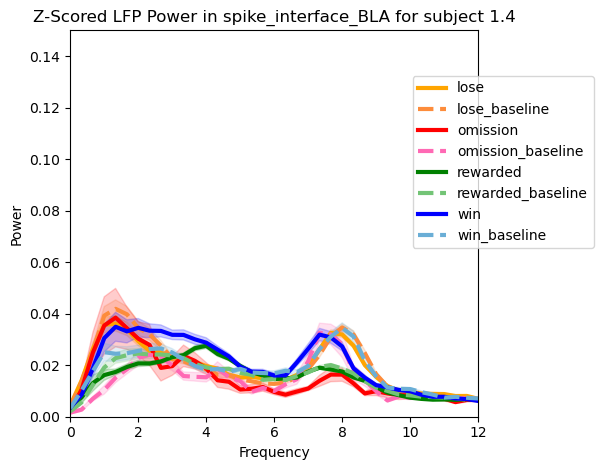

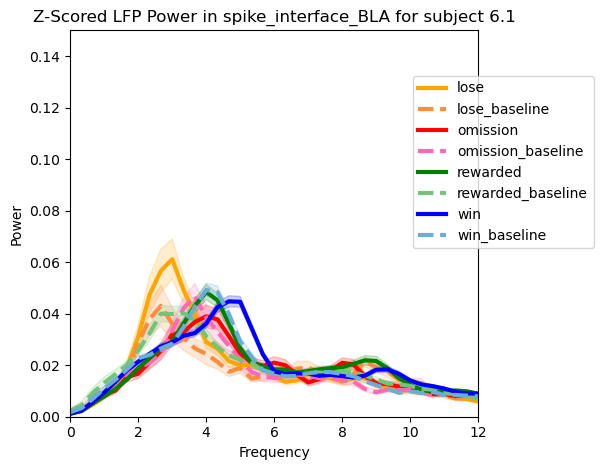

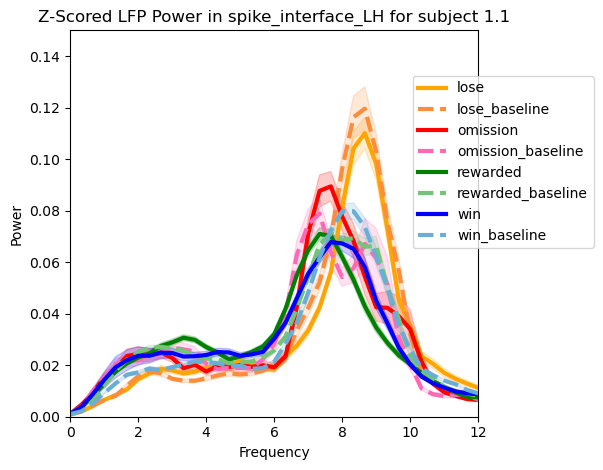

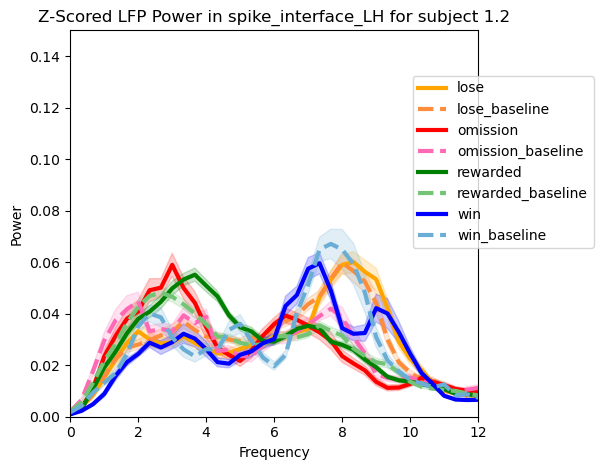

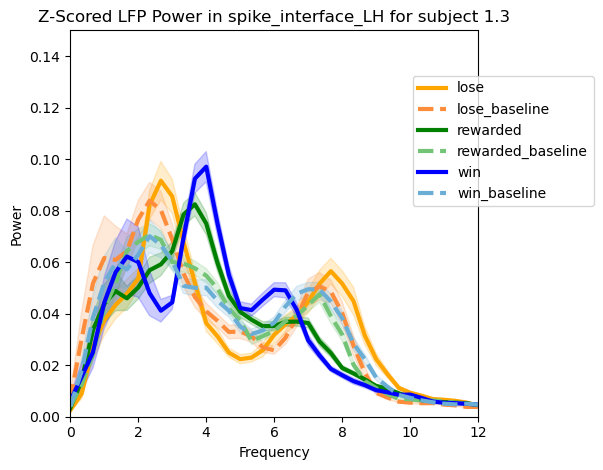

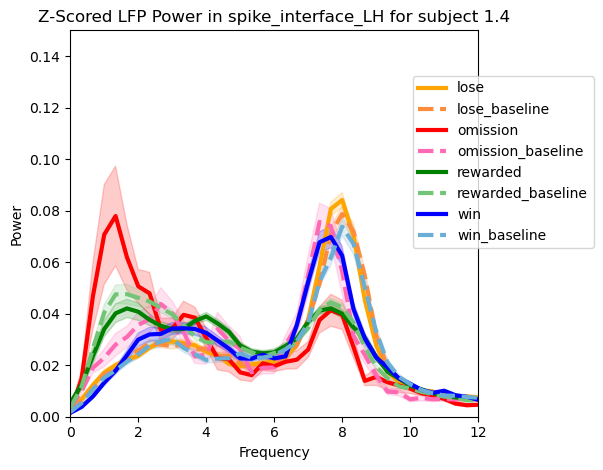

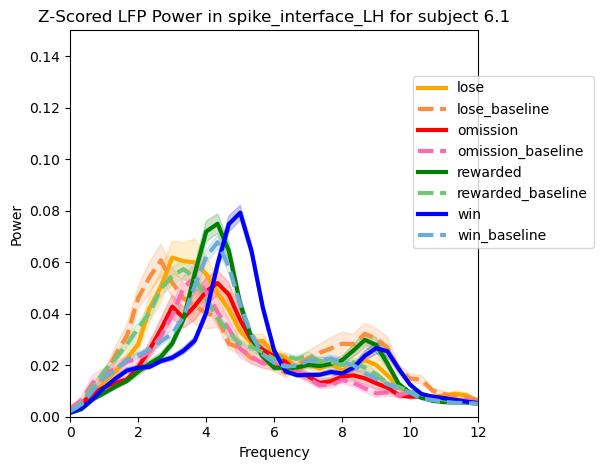

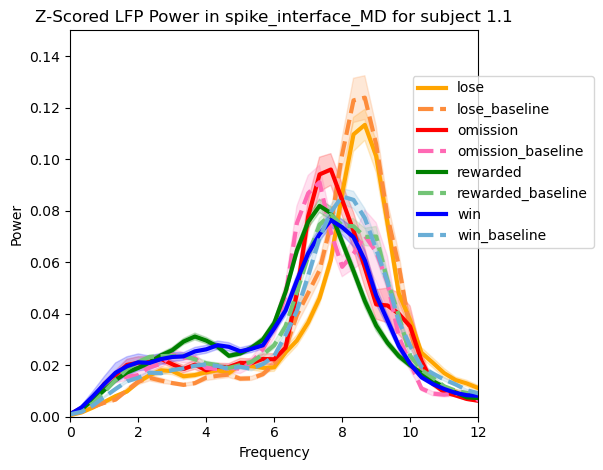

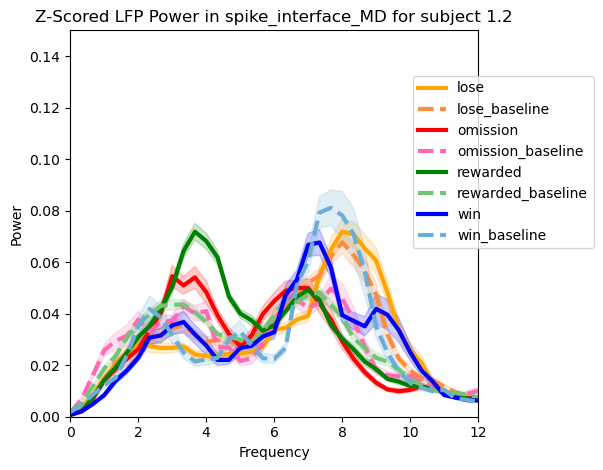

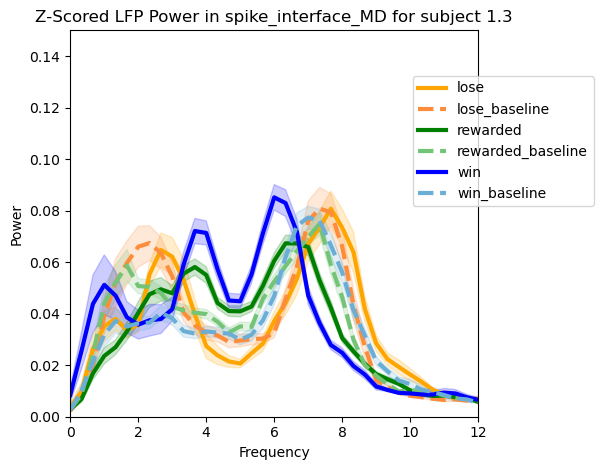

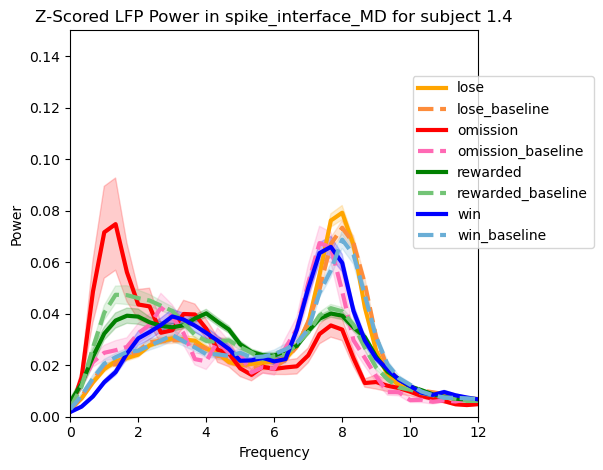

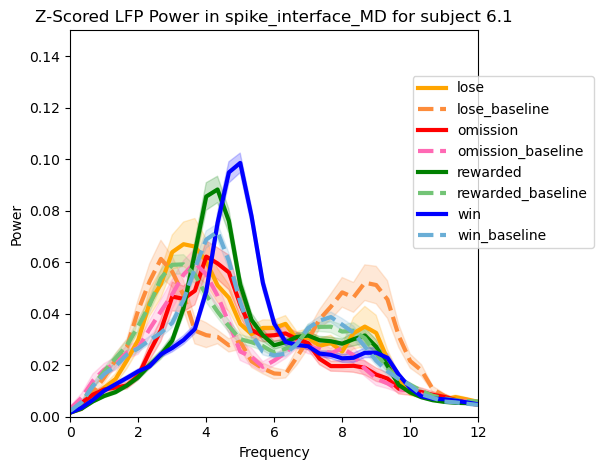

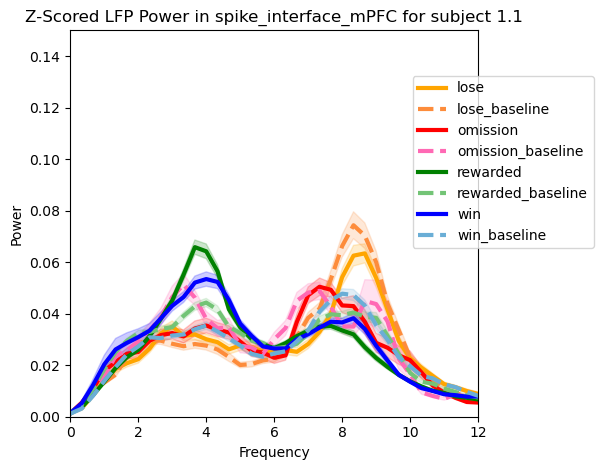

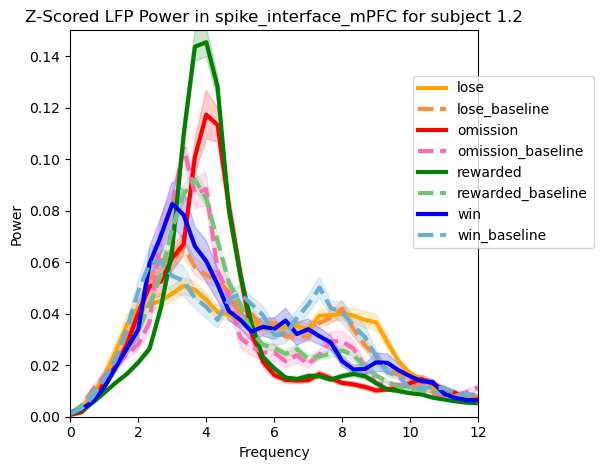

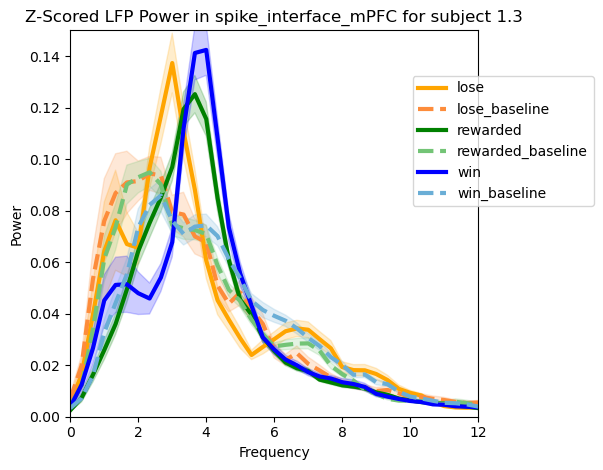

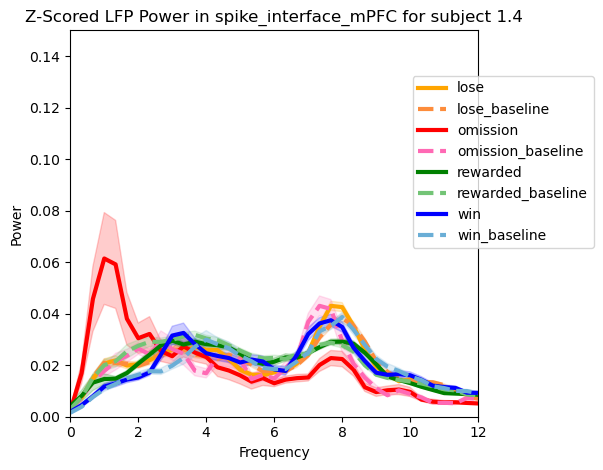

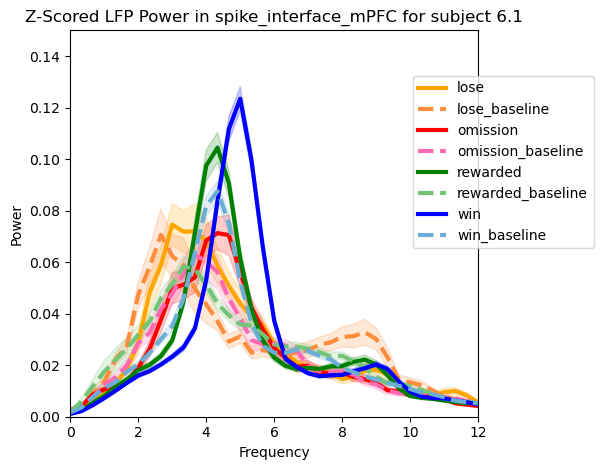

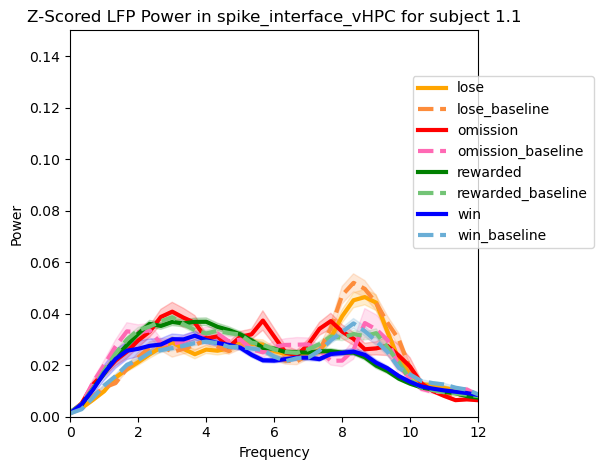

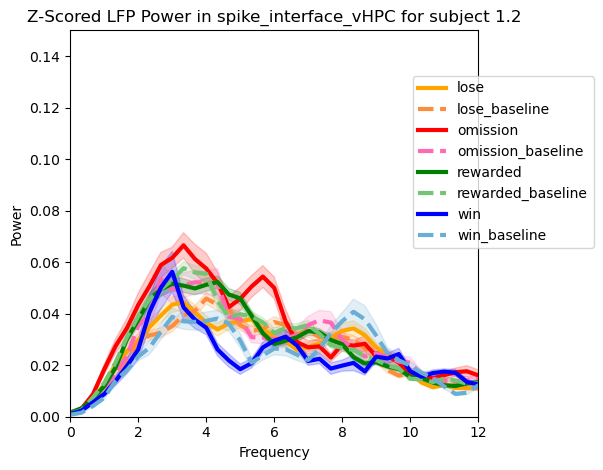

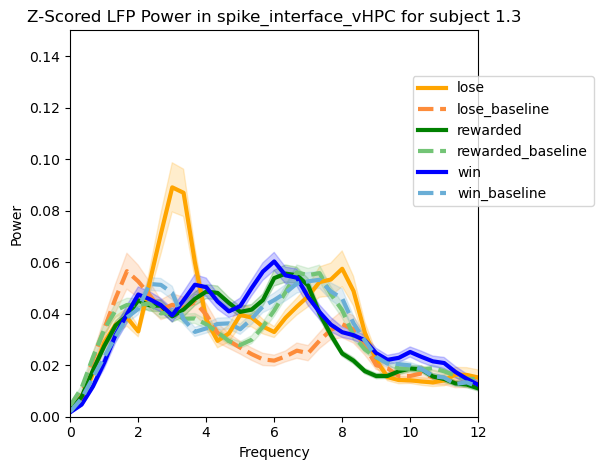

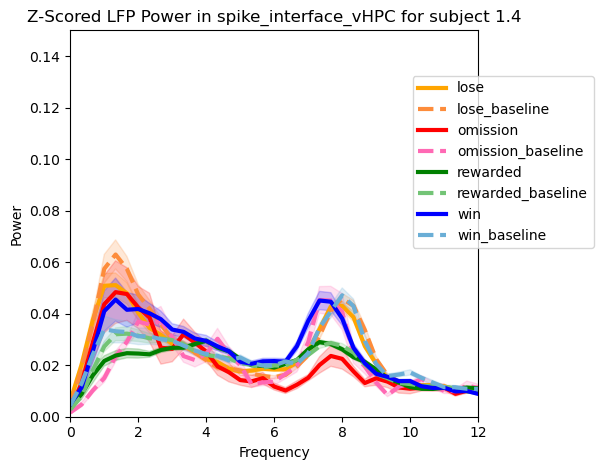

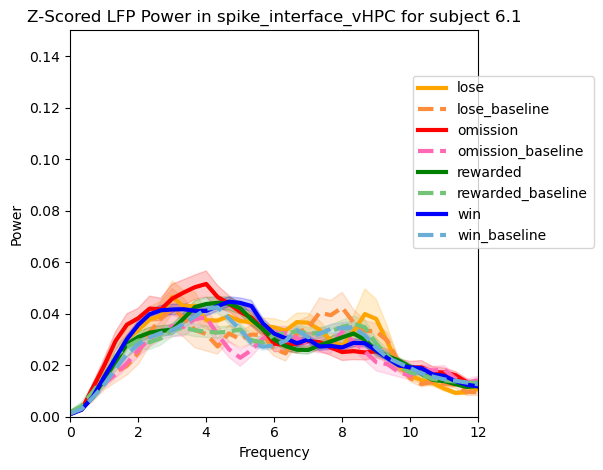

In [76]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    for subj in region_df["current_subject"].unique():
        subj_df = region_df[region_df["current_subject"] == subj]
    
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for subject {}".format(region, subj))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(0, 12)
        plt.ylim(0, 0.15)
        # plt.yscale("log")
    
        for outcome in subj_df["trial_outcome"].unique():
            outcome_df = subj_df[subj_df["trial_outcome"] == outcome]
            for index, row in outcome_df.iterrows():
                try:
                    # print(row["mean_power"])
                    ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{}".format(outcome), color=outcome_to_color[outcome], linestyle=outcome_to_style[outcome], linewidth=3)
                    # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                    plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
                except Exception as e: 
                    print(e)
                    continue
        ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
        plt.tight_layout()
        plt.savefig("./proc/z_scored_all_conditions_{}_subj_{}.png".format(region, subj))
        plt.show()
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

# Drawing plots all together

In [77]:
grouped_all_trials_df = melted_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_outcome']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [78]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [79]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [80]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [81]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

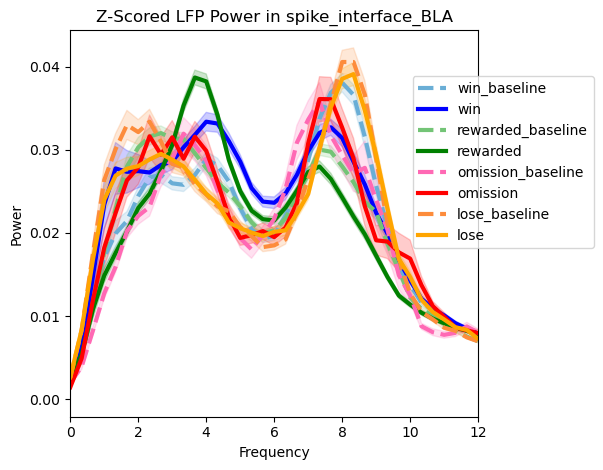

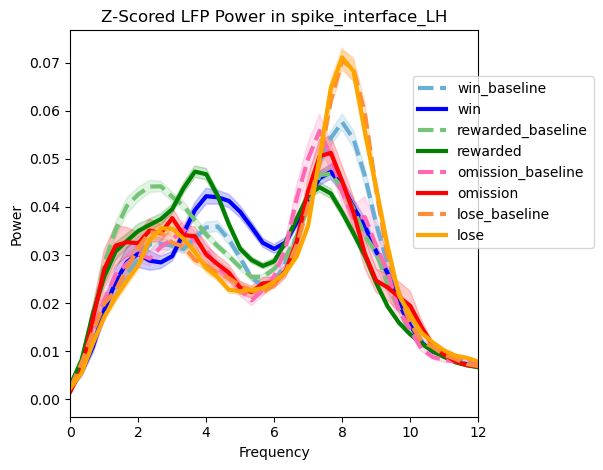

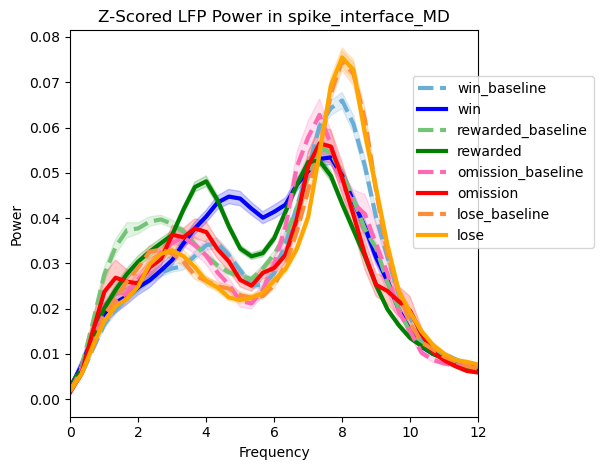

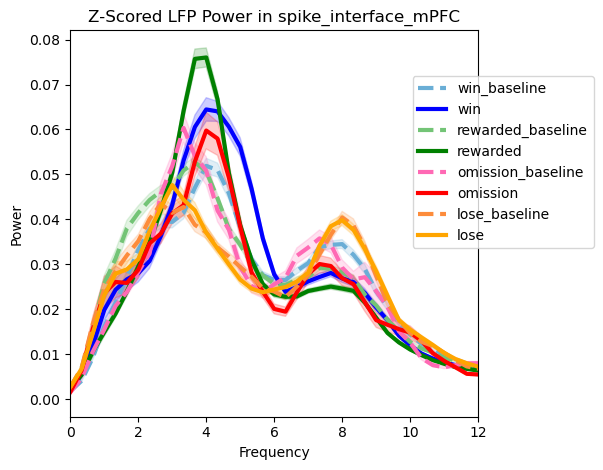

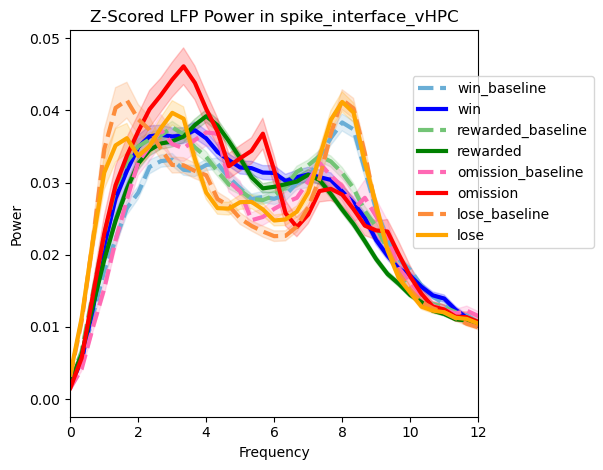

In [82]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    


    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 12)

    # plt.ylim(0, 0.15)
    # plt.yscale("log")

    for outcome in sorted(region_df["trial_outcome"].unique())[::-1]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{}".format(outcome), color=outcome_to_color[outcome], linestyle=outcome_to_style[outcome], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/z_scored_all_conditions_all_subj_{}_0_to_12hz.png".format(region, subj))
    plt.show()
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

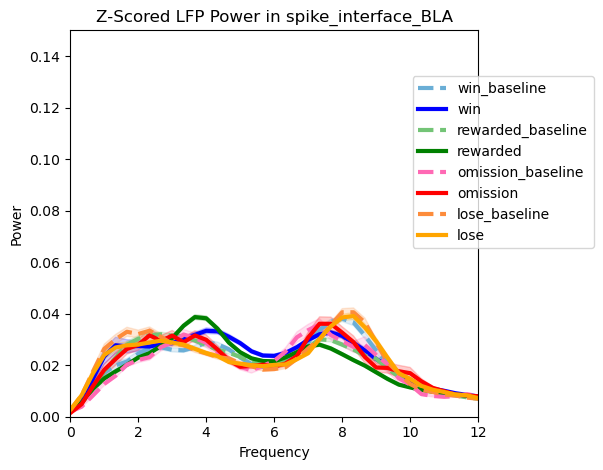

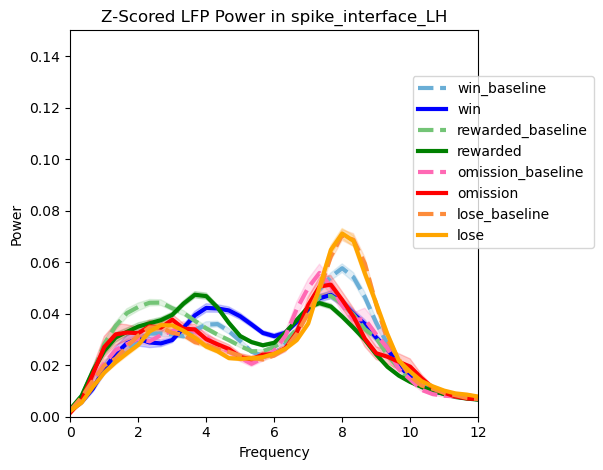

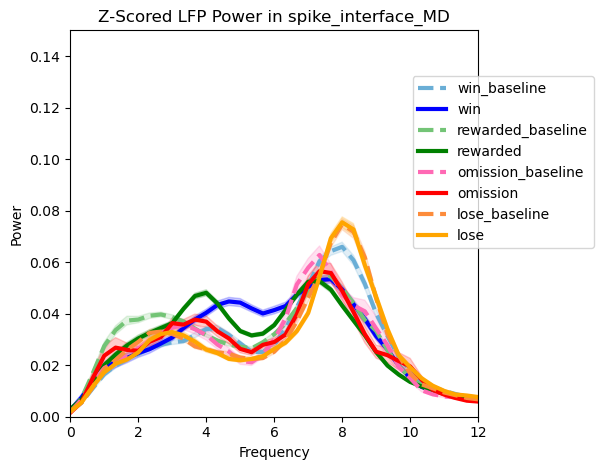

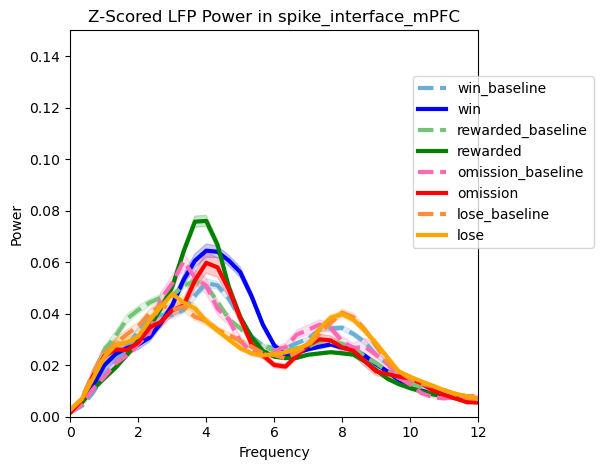

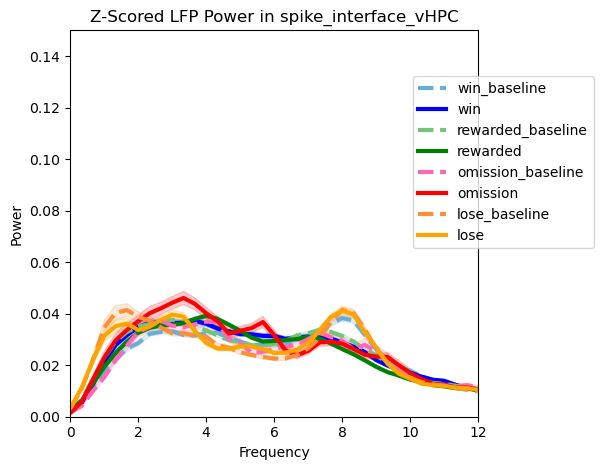

In [83]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    


    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 12)

    plt.ylim(0, 0.15)
    # plt.yscale("log")

    for outcome in sorted(region_df["trial_outcome"].unique())[::-1]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{}".format(outcome), color=outcome_to_color[outcome], linestyle=outcome_to_style[outcome], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/z_scored_all_conditions_all_subj_{}_0_to_12hz_with_ylim.png".format(region, subj))
    plt.show()
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

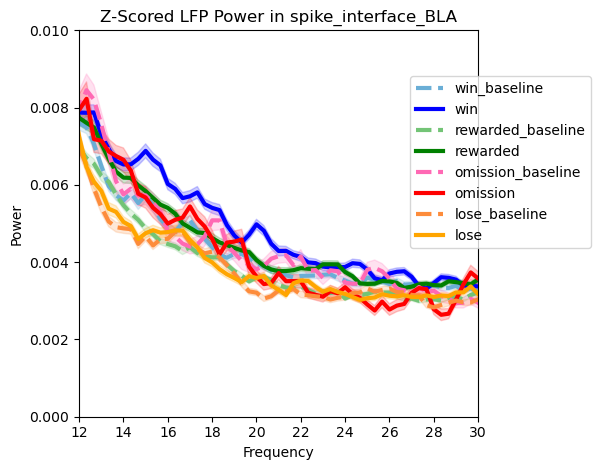

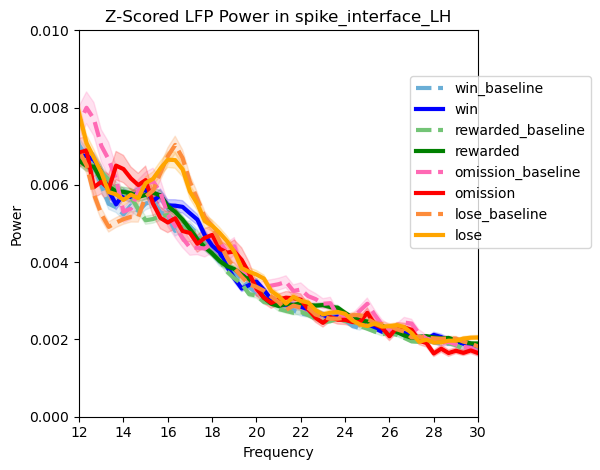

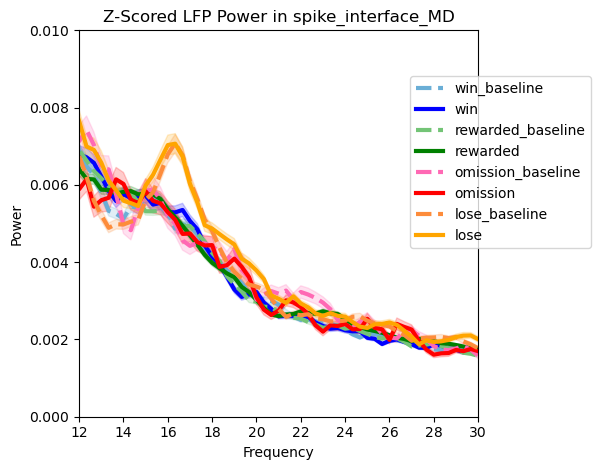

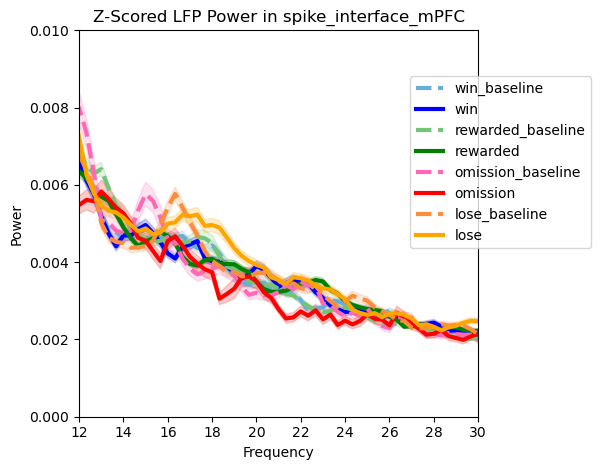

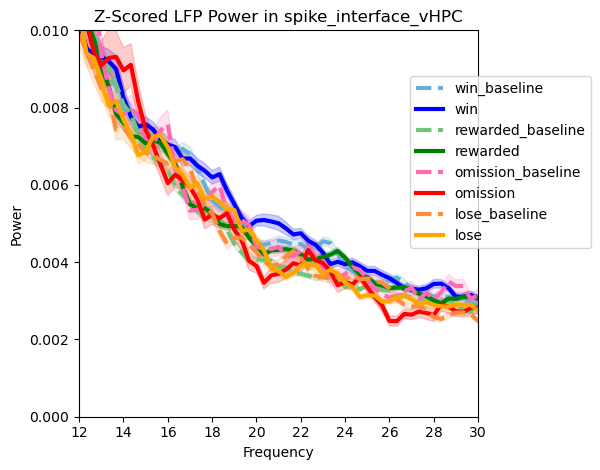

In [84]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    


    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(12, 30)

    plt.ylim(0, 0.01)
    # plt.yscale("log")

    for outcome in sorted(region_df["trial_outcome"].unique())[::-1]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{}".format(outcome), color=outcome_to_color[outcome], linestyle=outcome_to_style[outcome], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/z_scored_all_conditions_all_subj_{}_12_to_30hz.png".format(region, subj))
    plt.show()
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

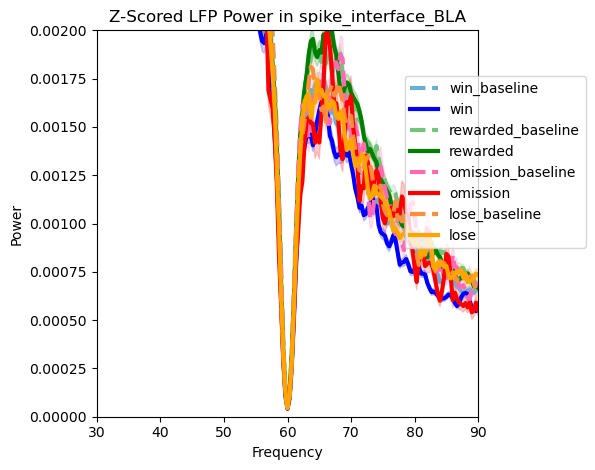

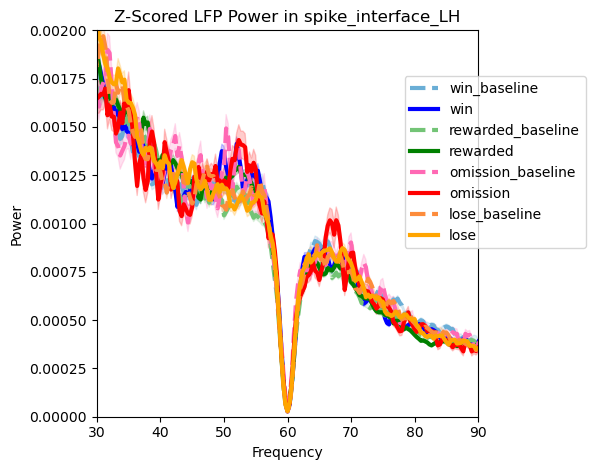

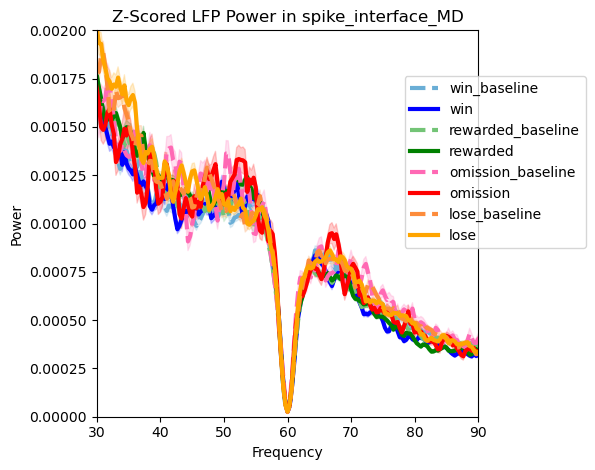

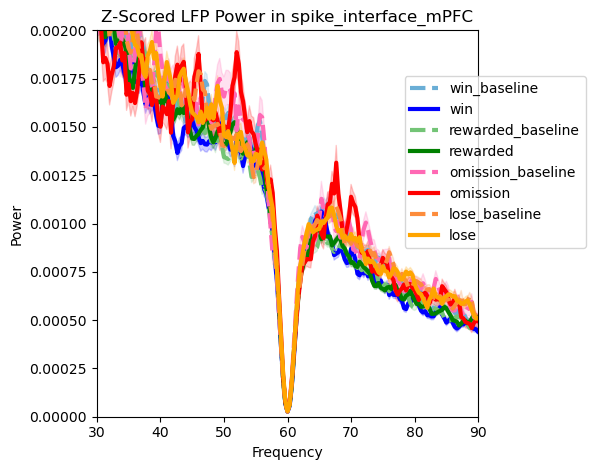

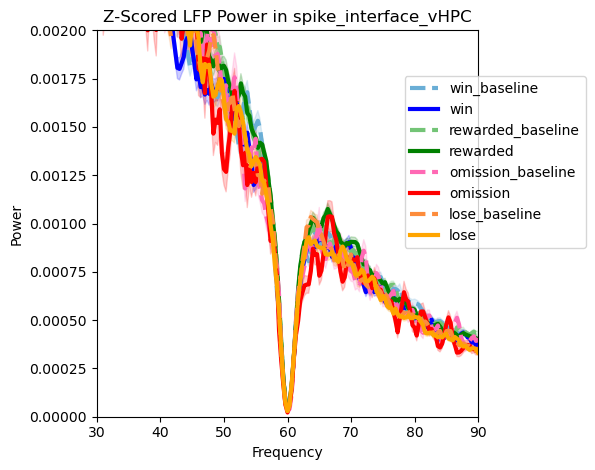

In [95]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    


    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(30, 90)

    plt.ylim(0, 0.002)
    # plt.yscale("log")

    for outcome in sorted(region_df["trial_outcome"].unique())[::-1]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            try:
                # print(row["mean_power"])
                ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{}".format(outcome), color=outcome_to_color[outcome], linestyle=outcome_to_style[outcome], linewidth=3)
                # ax.lines[0].set_linestyle(outcome_to_style[outcome])
                plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=outcome_to_color[outcome])
            except Exception as e: 
                print(e)
                continue
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/z_scored_all_conditions_all_subj_{}_30_to_90hz.png".format(region, subj))
    plt.show()
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))